### **2. Modelo de Optimización de Precios**

Finalizado el análisis y con las interiorizaciones obtenidas, procedemos 
a crear el modelo para la optimización de precios, donde debemos contemplar 
primero el efecto combinado de precios y cantidad. Esto debido a que nos 
guiaremos del concepto de que que ambas métricas se relacionan. Entonces:
$$
D = D_0*(\frac{P}{P_0})^e
$$
Donde
- $D$ = Demanda
- $D_0$ = Demanda pronosticada
- $P_0$ = Precio actual
- $e$ = coeficiente de elasticidad

Podemos despejar $e$ de manera que:
$$
(\frac{D}{D_0}) = (\frac{P}{P_0})^e => e = \frac{log(\frac{D}{D_0})}{log(\frac{P}{P_0})}
$$

La demanda no depende exclusivamente del precio, debido a que deberiamos 
considerar a la competencia, productos sustitutos y complementarios, etc. 

Los siguientes pasos fueron tomados en esta libreta:

1. Preparar los datos
2. Graficar el efecto de demanda por precio, asumiendo otros efectos estáticos
3. Predecir la demanda para un periodo según solicitado
4. Calcular el mejor nivel de precios y el revenue esperado

In [1]:
# Step 0. Load libraries and custom functions
# Dataframes, vectors & matrices
import pandas as pd
import numpy as np
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Statistics
import scipy.stats as scp_stats
import statsmodels.api as sm
# Time series
import darts
from darts.models import ExponentialSmoothing

/Users/alexismena/Documents/Data_Projects/Python/Pricing_Model/.venv/lib/python3.10/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


Procederemos a la carga de los datos y a un vistazo a los mismos:

In [2]:
# Step 1. Load dataset
# 1.1 Read csv and get basic info
df_raw = pd.read_csv('../data/ventas_final.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10879 entries, 0 to 10878
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fecha_Formato     10879 non-null  object 
 1   Fecha             10879 non-null  object 
 2   Codigo            10879 non-null  int64  
 3   Descripcion       10879 non-null  object 
 4   Precio_Unitario   10879 non-null  float64
 5   Costo_Unitario    10879 non-null  float64
 6   Cantidad_Vendida  10879 non-null  float64
 7   Ganancia          10879 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 680.1+ KB


In [3]:
# 1.2 Get a sample
df_raw.sample(5, random_state=2024)

,Fecha_Formato,Fecha,Codigo,Descripcion,Precio_Unitario,Costo_Unitario,Cantidad_Vendida,Ganancia
10849,2024-02-05,2024-06,10121151,BIPACK NOSOTRAS 2 INV DEO 10UN,18.2,17.98,5.0,1.10
3320,2023-01-30,2023-05,100714,HUEVO ROLON M.CORTADO 12U,12.9,10.00,9.0,26.10
1150,2022-10-17,2022-42,10108320,CHOCOLATE SUBLIME CLASICO 100GR,12.5,12.00,1.0,0.50
7147,2022-10-24,2022-43,10000095,GASEOSA PEPSI 500ML,3.5,3.22,28.0,7.84
6449,2023-06-19,2023-25,10022018,PAPEL HIG CONFORT 12UN,74.1,63.71,5.0,51.95


Debido a que grabamos los datos en formato csv en el anterior notebook, 
debemos darle el formato y establecer el índice con las fechas.

In [4]:
# 1.3 Transform the data as in the previous notebook
df_interim = df_raw.copy()
df_interim = df_interim.set_index(['Fecha_Formato'])
df_interim['Codigo'] = df_interim['Codigo'].astype(str)
df_interim.sample(5, random_state=2024)

,Fecha,Codigo,Descripcion,Precio_Unitario,Costo_Unitario,Cantidad_Vendida,Ganancia
Fecha_Formato,,,,,,,
2024-02-05,2024-06,10121151,BIPACK NOSOTRAS 2 INV DEO 10UN,18.2,17.98,5.0,1.10
2023-01-30,2023-05,100714,HUEVO ROLON M.CORTADO 12U,12.9,10.00,9.0,26.10
2022-10-17,2022-42,10108320,CHOCOLATE SUBLIME CLASICO 100GR,12.5,12.00,1.0,0.50
2022-10-24,2022-43,10000095,GASEOSA PEPSI 500ML,3.5,3.22,28.0,7.84
2023-06-19,2023-25,10022018,PAPEL HIG CONFORT 12UN,74.1,63.71,5.0,51.95


Luego tendremos nuestro dataset final

In [5]:
# 1.4 Create a copy
df = df_interim.copy()

Ahora procederemos a analizar como se comporta el precio con la demanda. 
Para ello haremos una gráfica por cada producto, y haremos una regresión 
lineal en cada uno, evaluando el índice de correlación y el p-value, el 
cual estableceremos como $\alpha$=0.05 como corte para la decisión.

Figura 1. Diagrama de demanda precio por producto


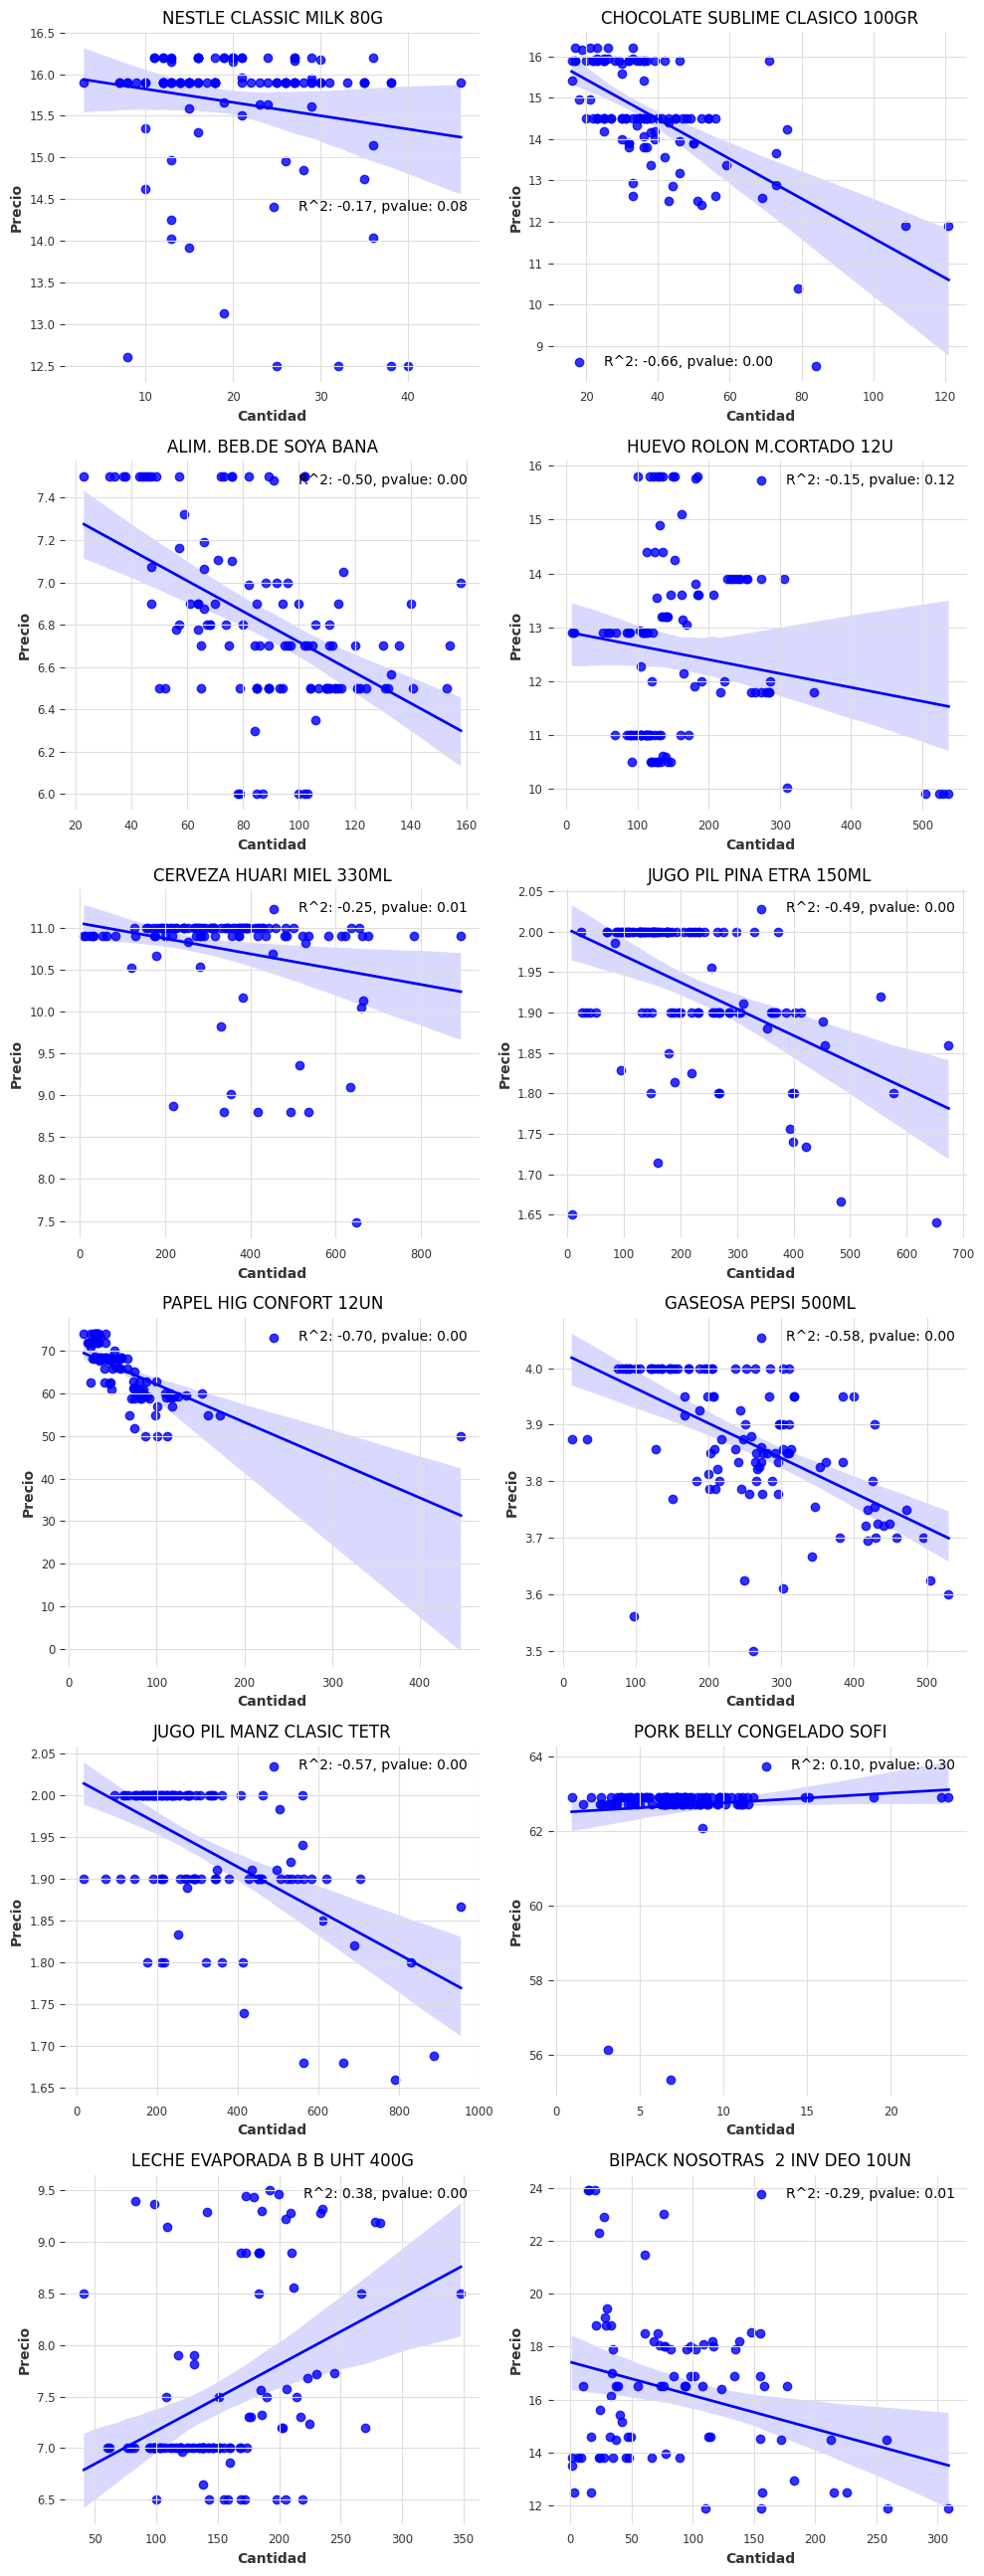

In [6]:
# Step 2. Analizar el efecto demanda precio
# 2.1 Correlación demanda-precio
print('Figura 1. Diagrama de demanda precio por producto')
categories = df['Descripcion'].unique().tolist()
fig, axs = plt.subplots(6,2,figsize=(10,26))
for i, ax in enumerate(axs.flatten()):
    temp_df = df[df['Descripcion']==categories[i]].\
        reset_index().groupby(['Fecha_Formato']).\
            agg({'Cantidad_Vendida':'sum', 'Precio_Unitario':'mean'})
    r, p = scp_stats.pearsonr(temp_df['Cantidad_Vendida'], temp_df['Precio_Unitario'])
    sns.regplot(x='Cantidad_Vendida', 
                y='Precio_Unitario', 
                data=temp_df, 
                ax=ax, color='b', label=f'R^2: {r:.2f}, pvalue: {p:.2f}')
    ax.set_title(categories[i])
    ax.legend()
    ax.set_xlabel('Cantidad')
    ax.set_ylabel('Precio')
plt.tight_layout()
plt.show()

En este caso la expectativa es que si el precio disminuye se incrementa 
la demanda y viceversa. Casi todos los productos tienen esa tendencia, 
excepto la panceta y la leche evaporada. Los productos con mayor correlación 
son el papel hig, el jugo pil manz., la gaseosa pepsi y el jugo pil pina. 
Aquí empieza el cuestionamiento, ya que hay productos que parecen incrementar 
la cantidad demandada conforme se incrementa el precio, sin embargo el 
coeficiente de correlación es bajo, es decir que hay un componente grande 
de varianza que no se puede explicar, como el caso de la leche evaporada.

Ahora procederemos a evaluar como se distribuyen los precios mediante un 
histograma de valores.

Figura 2. Histograma de precios de productos


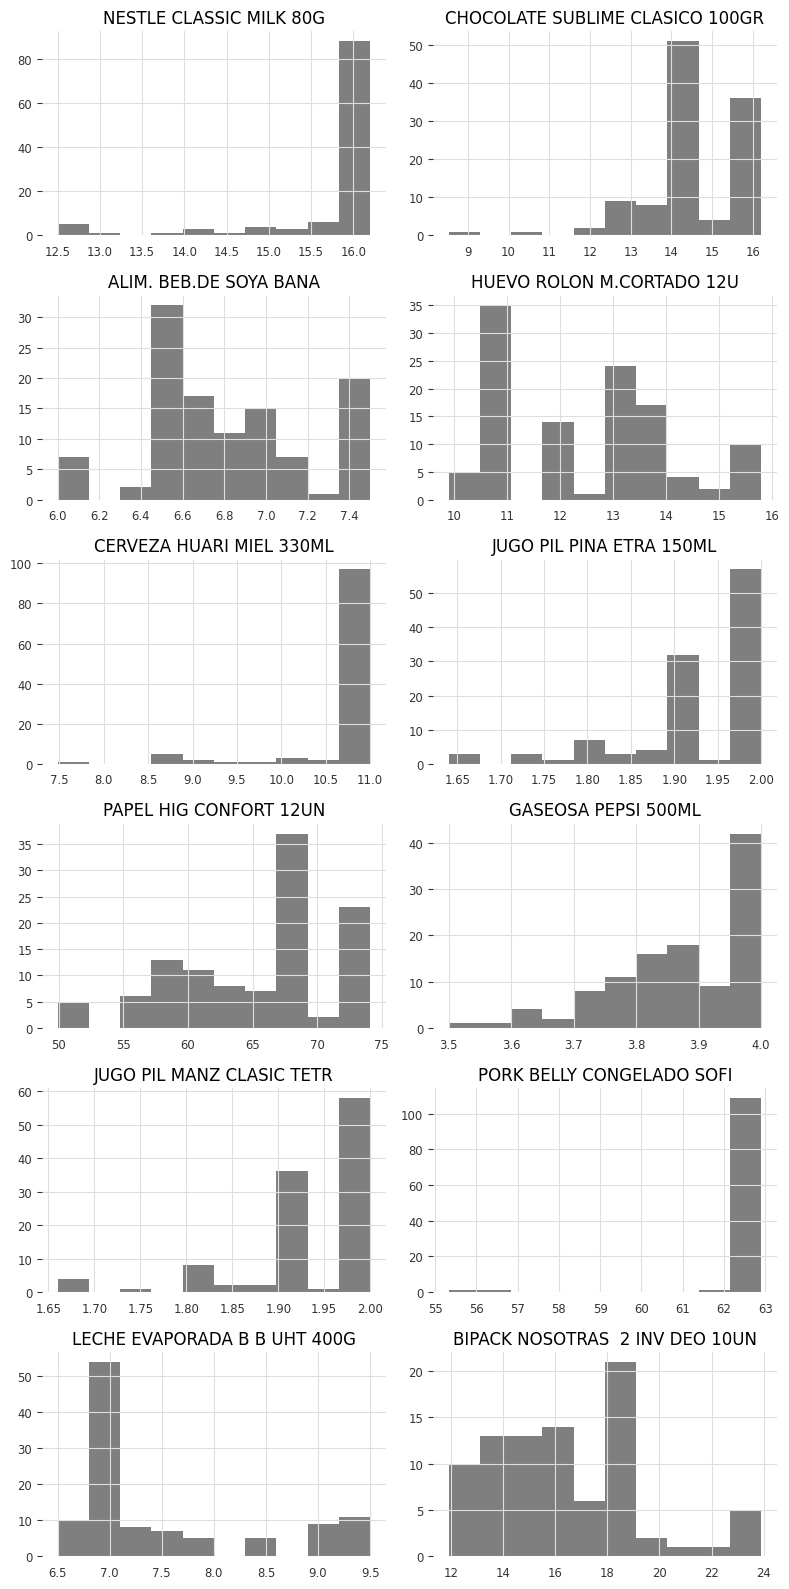

In [12]:
# 2.2 Plot price histogram
print('Figura 2. Histograma de precios de productos')
categories = df['Descripcion'].unique().tolist()
fig, axs = plt.subplots(6,2,figsize=(8,16))
for i, ax in enumerate(axs.flatten()):
    temp_df = df[df['Descripcion']==categories[i]].\
        reset_index().groupby(['Fecha_Formato']).\
            agg({'Cantidad_Vendida':'sum', 'Precio_Unitario':'mean'})
    ax.hist(temp_df['Precio_Unitario'], alpha=0.5, label='Precio')
    ax.set_title(categories[i])
plt.tight_layout()
plt.show()

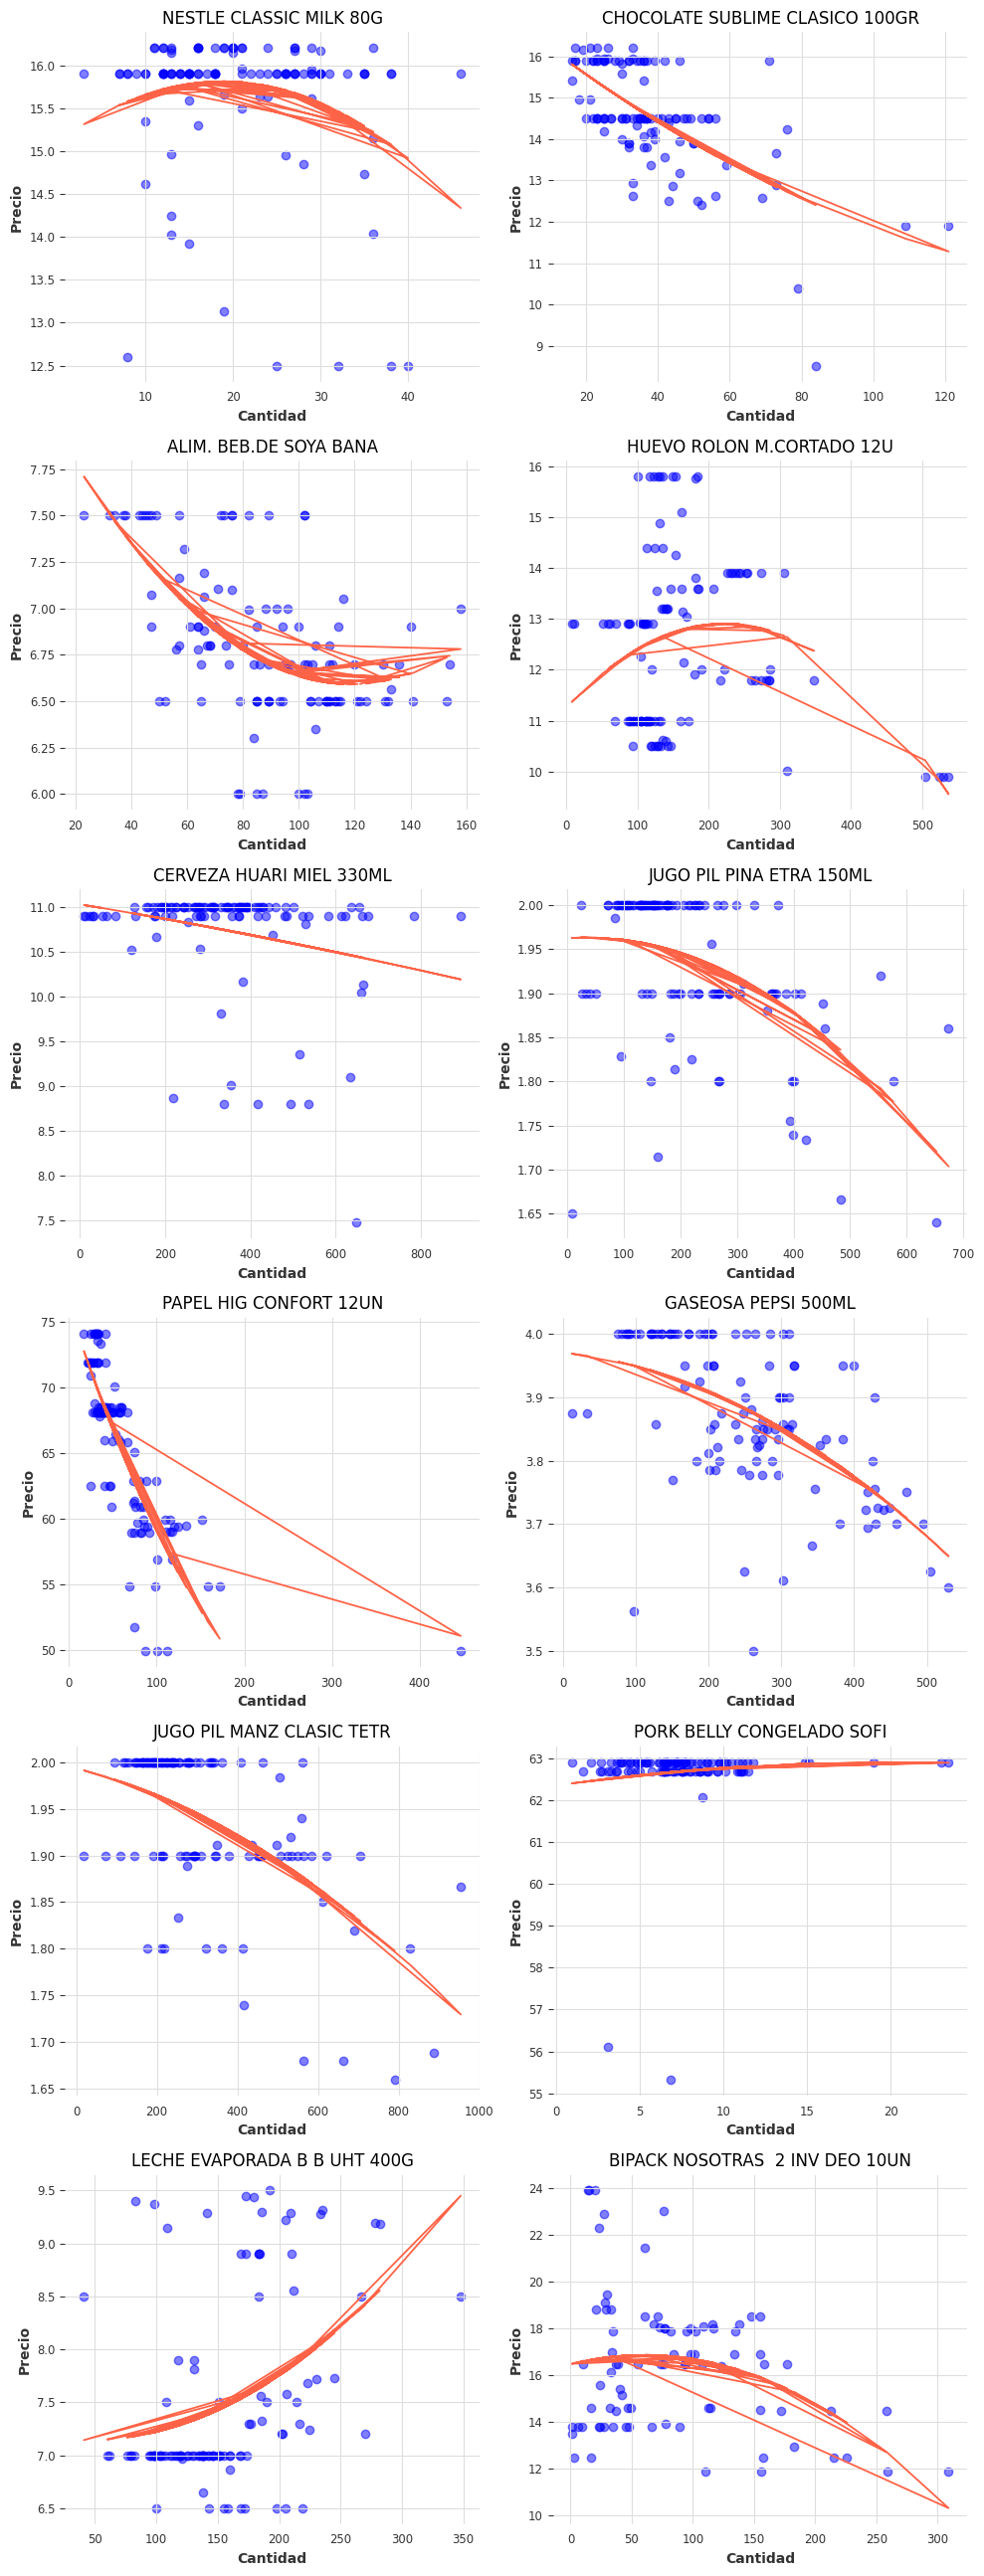

In [8]:
categories = df['Descripcion'].unique().tolist()
fig, axs = plt.subplots(6,2,figsize=(10,26))
for i, ax in enumerate(axs.flatten()):
    temp_df = df[df['Descripcion']==categories[i]].\
        reset_index().groupby(['Fecha_Formato']).\
            agg({'Cantidad_Vendida':'sum', 'Precio_Unitario':'mean'})
    z = np.polyfit(temp_df['Cantidad_Vendida'],temp_df['Precio_Unitario'],2)
    p = np.poly1d(z)
    ax.scatter(temp_df['Cantidad_Vendida'],
               temp_df['Precio_Unitario'], 
               c='b', alpha=0.5)
    ax.plot(temp_df['Cantidad_Vendida'],p(temp_df['Cantidad_Vendida']), c='Tomato')
    ax.set_title(categories[i])
    ax.set_xlabel('Cantidad')
    ax.set_ylabel('Precio')
plt.tight_layout()
plt.show()

In [9]:
# Model
mydf = df[df['Descripcion']=='GASEOSA PEPSI 500ML'].reset_index().groupby(['Fecha_Formato']).\
            agg({'Cantidad_Vendida':'sum'})
series = darts.TimeSeries.from_dataframe(mydf,'Cantidad_Vendida', freq='W')
#series = darts.TimeSeries.from_dataframe(df, "Month", "#Passengers")

# Set aside the last 36 months as a validation series
train, val = series[:-36], series[-36:]
train, val = series[:-6], series[-6:]

AttributeError: Invalid type of `time_col`: it needs to be of either 'str', 'datetime' or 'int' dtype.


AttributeError: Invalid type of `time_col`: it needs to be of either 'str', 'datetime' or 'int' dtype.

In [ ]:
mydf = df[df['Descripcion']=='GASEOSA PEPSI 500ML'].reset_index().groupby(['Fecha_Formato']).\
            agg({'Cantidad_Vendida':'sum'}).reset_index()
idx = pd.DatetimeIndex(mydf['Fecha_Formato'])
mydf = mydf.set_index(idx)
mydf = mydf.drop('Fecha_Formato', axis=1)  
mydf

,Cantidad_Vendida
Fecha_Formato,
2022-01-03,149.0
2022-01-10,87.0
2022-01-17,86.0
2022-01-24,81.0
2022-01-31,76.0
...,...
2024-01-22,127.0
2024-01-29,200.0
2024-02-05,195.0


In [ ]:
mydf.resample('W').sum()

,Cantidad_Vendida
Fecha_Formato,
2022-01-09,149.0
2022-01-16,87.0
2022-01-23,86.0
2022-01-30,81.0
2022-02-06,76.0
...,...
2024-01-28,127.0
2024-02-04,200.0
2024-02-11,195.0


In [ ]:
series = darts.TimeSeries.from_dataframe(mydf, value_cols='Cantidad_Vendida')
train, val = series[:-8], series[-8:]

In [ ]:
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val))

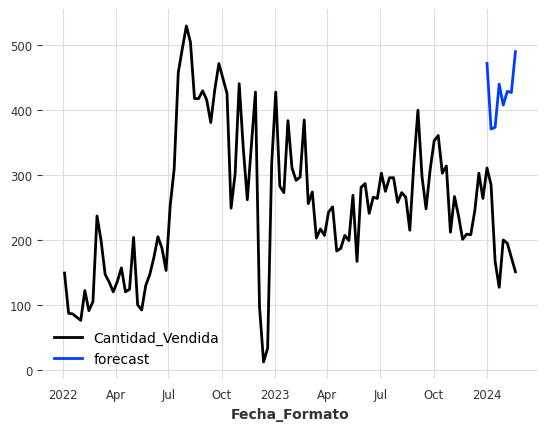

In [ ]:
series.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [ ]:
mydf

In [ ]:
mydf.resample('W').sum()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [ ]:
mydf

,Fecha_Formato,Cantidad_Vendida
0,2022-01-03,149.0
1,2022-01-10,87.0
2,2022-01-17,86.0
3,2022-01-24,81.0
4,2022-01-31,76.0
...,...,...
107,2024-01-22,127.0
108,2024-01-29,200.0
109,2024-02-05,195.0
110,2024-02-12,173.0


In [ ]:
train

<TimeSeries (DataArray) (Fecha_Formato: 772, component: 1, sample: 1)> Size: 6kB
array([[[149.]],

       [[ nan]],

       [[ nan]],

       [[ nan]],

       [[ nan]],

       [[ nan]],

       [[ nan]],

       [[ 87.]],

       [[ nan]],

       [[ nan]],

...

       [[ nan]],

       [[195.]],

       [[ nan]],

       [[ nan]],

       [[ nan]],

       [[ nan]],

       [[ nan]],

       [[ nan]],

       [[173.]],

       [[ nan]]])
Coordinates:
  * Fecha_Formato  (Fecha_Formato) datetime64[ns] 6kB 2022-01-03 ... 2024-02-13
  * component      (component) object 8B 'Cantidad_Vendida'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(n=6, num_samples=5)

/Users/alexismena/Documents/Data_Projects/Python/Pricing_Model/.venv/lib/python3.10/site-packages/statsmodels/tsa/exponential_smoothing/initialization.py:95: RuntimeWarning: Mean of empty slice
  initial_seasonal = np.nanmean(


ValueError: shapes (2,10) and (0,1) not aligned: 10 (dim 1) != 0 (dim 0)

In [ ]:
series.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()